### iNaturlist 
* [#179](https://github.com/salgo60/Stockholm_Archipelago_Trail/issues/179) "Koppla SAT till artobservationer"
* [this Notebook](https://github.com/salgo60/Stockholm_Archipelago_Trail/tree/main/notebook/SAT179_iNaturalist.ipynb)

In [1]:
import time
import datetime  
start_time = time.time()
start_str = datetime.datetime.now().strftime("%Y-%m-%d %H:%M")
print(f"Started: {start_str}")


Started: 2025-09-21 22:41


1) Läs leden från lokal GeoJSON "SAT_full.geojson"
2) Buffert runt leden som sökzon för iNat BUFFER_DEG

Funka ej

In [2]:
# i en notebook-cell (en gång)
!pip install -q tqdm
from tqdm.auto import tqdm 
import json, time, requests, folium
from folium.plugins import TimestampedGeoJson
from shapely.geometry import shape, LineString, MultiLineString, Polygon, MultiPolygon
from shapely.ops import unary_union
from shapely.geometry import mapping

# --- 0) Läs leden från lokal GeoJSON ---
with open("SAT_full.geojson", encoding="utf-8") as f:
    gj = json.load(f)

lines = []
for feat in gj["features"]:
    g = shape(feat["geometry"])
    if isinstance(g, LineString):
        if len(g.coords) >= 2: lines.append(g)
    elif isinstance(g, MultiLineString):
        for seg in g.geoms:
            if len(seg.coords) >= 2: lines.append(seg)

if not lines:
    raise ValueError("SAT_full.geojson innehåller inga linjesegment.")

trail = unary_union(lines)
center_lat, center_lon = trail.centroid.y, trail.centroid.x

# --- 1) Buffert runt leden som sökzon för iNat ---
BUFFER_DEG = 0.003  # ~300 m vid 59–60° lat, justera vid behov
search_geom = trail.buffer(BUFFER_DEG)
if isinstance(search_geom, (Polygon, MultiPolygon)):
    search_geom = search_geom.simplify(0.0002, preserve_topology=True)

# --- 2) iNaturalist helpers (loopar alla delpolygoner) ---  
import time, requests
from shapely.geometry import shape, Polygon, MultiPolygon, LineString
from shapely.ops import unary_union

INAT_URL = "https://api.inaturalist.org/v1/observations"

import time, requests
from shapely.geometry import shape, Polygon, MultiPolygon, LineString
from shapely.ops import unary_union

INAT_URL = "https://api.inaturalist.org/v1/observations"

def _polygon_param_from_poly(poly: Polygon, simplify_tol: float = 0.0002, step: int = 1):
    p = poly.simplify(simplify_tol, preserve_topology=True)
    ring = list(p.exterior.coords)[::step]
    if ring[0] != ring[-1]:
        ring.append(ring[0])
    return ",".join(f"{lng},{lat}" for (lng, lat) in ring)

def _bbox_params_from_poly(poly: Polygon):
    minx, miny, maxx, maxy = poly.bounds
    return {"swlng": minx, "swlat": miny, "nelng": maxx, "nelat": maxy}

def _inat_query_for_polygon(poly: Polygon, params_base: dict, per_page=200, max_pages=5, pause=0.2, pbar=None):
    """
    Kör iNat mot polygon. Har adaptiv förenkling + bbox-fallback.
    Uppdaterar valfri tqdm-progressbar efter varje hämtad sida.
    """
    results = []
    params = dict(params_base)
    params.update({
        "verifiable": "true",
        "order_by": "observed_on",
        "order": "desc",
        "per_page": per_page
    })

    # 1) adaptiv polygon (för att undvika 414)
    for simplify_tol in (0.0002, 0.0004, 0.0008, 0.0016):
        for step in (1, 2, 3, 4):
            polygon_param = _polygon_param_from_poly(poly, simplify_tol=simplify_tol, step=step)
            params_poly = dict(params, polygon=polygon_param)
            try:
                # Första sidan
                r = requests.get(INAT_URL, params=dict(params_poly, page=1), timeout=30)
                if r.status_code == 414:
                    raise requests.HTTPError("414 URI Too Large (polygon)", response=r)
                r.raise_for_status()
                data = r.json()
                batch = data.get("results", [])
                results.extend(batch)
                if pbar: pbar.update(1)

                # Paginerat
                for page in range(2, max_pages + 1):
                    r = requests.get(INAT_URL, params=dict(params_poly, page=page), timeout=30)
                    r.raise_for_status()
                    b2 = r.json().get("results", [])
                    results.extend(b2)
                    if pbar: pbar.update(1)
                    if len(b2) < per_page:
                        break
                    time.sleep(pause)
                return results
            except requests.HTTPError as e:
                # prova nästa simplifiering—bubbla inte upp 414
                if getattr(e, "response", None) is None or e.response.status_code != 414:
                    raise

    # 2) Fallback till bbox
    params_bbox = dict(params, **_bbox_params_from_poly(poly))
    for page in range(1, max_pages + 1):
        r = requests.get(INAT_URL, params=dict(params_bbox, page=page), timeout=30)
        r.raise_for_status()
        b = r.json().get("results", [])
        results.extend(b)
        if pbar: pbar.update(1)
        if len(b) < per_page:
            break
        time.sleep(pause)
    return results

def fetch_inat_all_parts(geom_like,
                         iconic_taxa=None, d1=None, d2=None,
                         per_page=200, max_pages=5, pause=0.2,
                         show_progress=True, desc="Fetch"):
    """
    Tar LineString/Polygon/MultiPolygon, buffrar vid behov, loopar delpolygoner,
    deduplar observationer och visar progressbar.
    """
    g = geom_like if hasattr(geom_like, "geom_type") else shape(geom_like)
    if g.geom_type == "LineString":
        g = g.buffer(0.0015)  # ~150 m
    elif g.geom_type not in ("Polygon", "MultiPolygon"):
        g = unary_union(g)

    polys = [g] if isinstance(g, Polygon) else [p for p in g.geoms if p.area > 1e-10]

    base = {}
    if iconic_taxa: base["iconic_taxa"] = iconic_taxa
    if d1: base["d1"] = d1
    if d2: base["d2"] = d2

    total_steps = len(polys) * max_pages  # ungefärligt (per polygon x sidor)
    pbar = tqdm(total=total_steps, desc=desc, unit="page", leave=False) if show_progress else None

    all_obs = {}
    try:
        for poly in polys:
            part = _inat_query_for_polygon(poly, base, per_page=per_page, max_pages=max_pages, pause=pause, pbar=pbar)
            for o in part:
                all_obs[o["id"]] = o
    finally:
        if pbar: pbar.close()
    return list(all_obs.values())


# --- 3) Hämta data (~1000 per kategori om det finns) --- 
from datetime import date, timedelta
d2 = date.today().isoformat()
d1 = (date.today() - timedelta(days=20)).isoformat()  # senaste 30 dagarna

# Växter
plants = fetch_inat_all_parts(search_geom, iconic_taxa="Plantae", d1=d1, d2=d2,
                              per_page=200, max_pages=5, show_progress=True, desc="Plantae")

# Djur (visa övergripande progress för taxagrupper)
animal_taxa = ["Aves","Mammalia","Reptilia","Amphibia","Insecta","Arachnida","Mollusca","Animalia"]
animals_all = []
with tqdm(total=len(animal_taxa), desc="Animal taxa", unit="taxon") as t_taxa:
    for tx in animal_taxa:
        part = fetch_inat_all_parts(search_geom, iconic_taxa=tx, d1=d1, d2=d2,
                                    per_page=200, max_pages=5, show_progress=True, desc=tx)
        animals_all.extend(part)
        t_taxa.update(1)
animals = list({o["id"]: o for o in animals_all}.values())
print(f"Växter: {len(plants)} | Djur: {len(animals)}")

# --- 4) Bygg FeatureCollections med 'time' + bild i popup ---
def obs_to_feature(o):
    if not o.get("geojson"): return None
    lon, lat = o["geojson"]["coordinates"]
    date = o.get("observed_on") or o.get("created_at") or ""
    taxon = o.get("taxon") or {}
    cname = taxon.get("preferred_common_name") or taxon.get("name") or "okänd"
    sname = taxon.get("name") or ""
    url   = f"https://www.inaturalist.org/observations/{o['id']}"
    img = ""
    photos = o.get("photos") or []
    if photos:
        raw = photos[0].get("url", "")
        if raw: img = raw.replace("square","medium")

    popup = f"<b>{cname}</b><br><i>{sname}</i><br>{date}<br>"
    if img: popup += f"<img src='{img}' width='220'><br>"
    popup += f"<a href='{url}' target='_blank'>Visa i iNaturalist</a>"

    return {
        "type":"Feature",
        "geometry":{"type":"Point","coordinates":[lon,lat]},
        "properties":{"time":date,"popup":popup}
    }

def to_fc(obs): 
    feats = [obs_to_feature(o) for o in obs]
    return {"type":"FeatureCollection","features":[f for f in feats if f]}

plants_fc  = to_fc(plants)
animals_fc = to_fc(animals)

# --- 5) Karta med separata tidslager ---
m = folium.Map(location=[center_lat, center_lon], zoom_start=10, control_scale=True)

# leden
folium.GeoJson(mapping(trail), name="SAT-led",
               style_function=lambda x: {"color":"#1e40af","weight":3}).add_to(m)

# (valfritt) visa bufferten
if isinstance(search_geom,(Polygon,MultiPolygon)):
    folium.GeoJson(mapping(search_geom), name="Sökzon",
                   style_function=lambda x: {"color":"#3388ff","weight":1,"fillOpacity":0.05}).add_to(m)

TimestampedGeoJson(plants_fc,  period="P1D", duration="P3D",
                   add_last_point=True, auto_play=True,  loop=True,
                   date_options="YYYY-MM-DD", name="Växter – tidsserie").add_to(m)

TimestampedGeoJson(animals_fc, period="P1D", duration="P3D",
                   add_last_point=True, auto_play=False, loop=True,
                   date_options="YYYY-MM-DD", name="Djur – tidsserie").add_to(m)

folium.LayerControl(collapsed=False).add_to(m)
m.save("inat_realtime_poc2.html")
print("Sparade: inat_realtime_poc2.html")


Plantae:   0%|          | 0/80 [00:00<?, ?page/s]

Animal taxa:   0%|          | 0/8 [00:00<?, ?taxon/s]

Aves:   0%|          | 0/80 [00:00<?, ?page/s]

Mammalia:   0%|          | 0/80 [00:00<?, ?page/s]

Reptilia:   0%|          | 0/80 [00:00<?, ?page/s]

Amphibia:   0%|          | 0/80 [00:00<?, ?page/s]

Insecta:   0%|          | 0/80 [00:00<?, ?page/s]

Mollusca:   0%|          | 0/80 [00:00<?, ?page/s]

Animalia:   0%|          | 0/80 [00:00<?, ?page/s]

Växter: 1058 | Djur: 8137


TypeError: TimestampedGeoJson.__init__() got an unexpected keyword argument 'name'

Aves:   0%|          | 0/80 [00:00<?, ?page/s]

Mammalia:   0%|          | 0/80 [00:00<?, ?page/s]

Reptilia:   0%|          | 0/80 [00:00<?, ?page/s]

Amphibia:   0%|          | 0/80 [00:00<?, ?page/s]

Insecta:   0%|          | 0/80 [00:00<?, ?page/s]

Arachnida:   0%|          | 0/80 [00:00<?, ?page/s]

Mollusca:   0%|          | 0/80 [00:00<?, ?page/s]

Animalia:   0%|          | 0/80 [00:00<?, ?page/s]

Bygger tidslager:   0%|          | 0/9 [00:00<?, ?it/s]

Plantae → features:   0%|          | 0/1058 [00:00<?, ?it/s]

TypeError: TimestampedGeoJson.__init__() got an unexpected keyword argument 'name'

In [8]:
# Number observations fetched 
for tx, obs in all_groups.items():
    print(f"{tx}: {len(obs)} observations")  

total_obs = sum(len(obs) for obs in all_groups.values())
print(f"Total observations fetched: {total_obs}")  
list(all_groups["Aves"][:3])  # look at first 3 bird obs


Plantae: 1058 observations
Aves: 1008 observations
Mammalia: 1001 observations
Reptilia: 1004 observations
Amphibia: 1001 observations
Insecta: 1019 observations
Arachnida: 1004 observations
Mollusca: 1001 observations
Animalia: 1001 observations
Total observations fetched: 9097


[{'quality_grade': 'needs_id',
  'time_observed_at': '2025-09-22T18:28:00+07:00',
  'taxon_geoprivacy': None,
  'annotations': [],
  'uuid': '733aa2c7-826d-4538-98b3-d1c2ad5fbc4b',
  'observed_on_details': {'date': '2025-09-22',
   'day': 22,
   'month': 9,
   'year': 2025,
   'hour': 18,
   'week': 39},
  'id': 315723865,
  'cached_votes_total': 0,
  'identifications_most_agree': False,
  'created_at_details': {'date': '2025-09-22',
   'day': 22,
   'month': 9,
   'year': 2025,
   'hour': 11,
   'week': 39},
  'species_guess': 'Burung',
  'identifications_most_disagree': False,
  'tags': [],
  'positional_accuracy': 7426,
  'comments_count': 1,
  'site_id': 1,
  'created_time_zone': 'Asia/Jakarta',
  'license_code': 'cc-by-nc',
  'observed_time_zone': 'Asia/Jakarta',
  'quality_metrics': [],
  'public_positional_accuracy': 7426,
  'reviewed_by': [8871024],
  'oauth_application_id': None,
  'flags': [],
  'created_at': '2025-09-22T11:04:36+07:00',
  'description': 'just curious about t

In [9]:
import pandas as pd

def summarize_by_date(observations, label=""):
    """Takes a list of iNat obs and returns a dataframe grouped by date"""
    rows = []
    for o in observations:
        date = o.get("observed_on") or o.get("created_at")
        if date:
            rows.append({"date": date[:10], "id": o["id"]})
    df = pd.DataFrame(rows)
    if df.empty:
        return pd.DataFrame(columns=["date","count"])
    summary = df.groupby("date").count().rename(columns={"id":"count"}).reset_index()
    summary["group"] = label
    return summary

# Example: make summaries for each group
dfs = []
for tx, obs in all_groups.items():
    dfs.append(summarize_by_date(obs, label=tx))

summary_all = pd.concat(dfs).sort_values(["date","group"])

summary_all.head(10)   # look at first 10 rows


,date,count,group
0,2025-09-21,938,Amphibia
0,2025-09-21,845,Animalia
0,2025-09-21,773,Arachnida
0,2025-09-21,404,Aves
0,2025-09-21,916,Mammalia
0,2025-09-21,797,Mollusca
0,2025-09-21,1058,Plantae
0,2025-09-21,894,Reptilia
1,2025-09-22,63,Amphibia
1,2025-09-22,156,Animalia


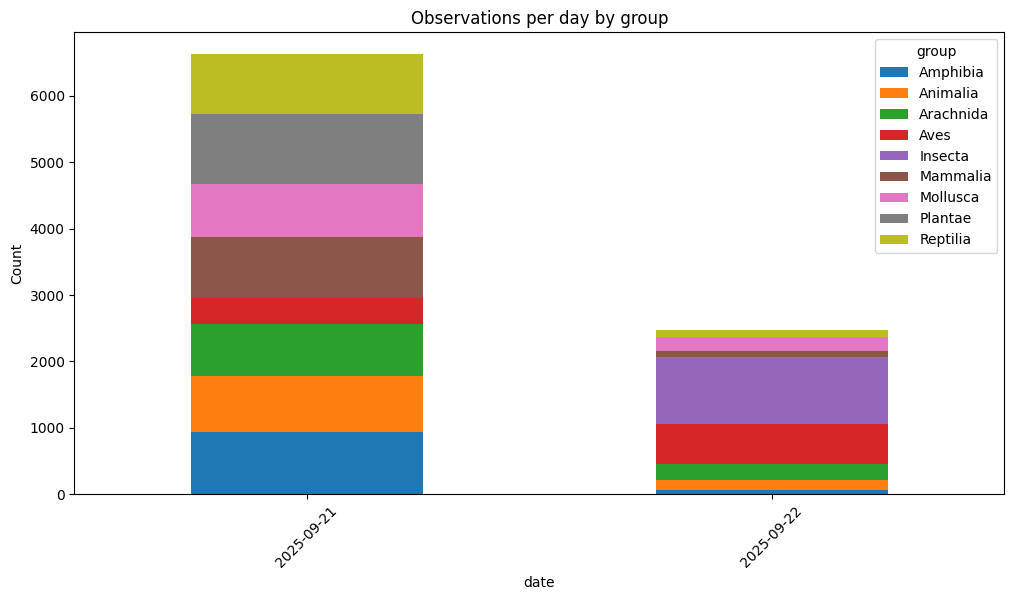

In [10]:
import matplotlib.pyplot as plt

pivot = summary_all.pivot(index="date", columns="group", values="count").fillna(0)

pivot.plot(kind="bar", stacked=True, figsize=(12,6))
plt.title("Observations per day by group")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()


In [ ]:
    end_time = time.time()
    duration = end_time - start_time
    print(f"GeoJSON saved to {output_path}")
    print(f"Finished in {duration:.2f} seconds.")
